In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

## **Hungarian algorithm**


  A function to solve the Minimum Cost Matching (Assignment Problem) using the Hungarian Algorithm.

This function takes a given performance (or cost) matrix Perf and returns:

a binary matching matrix Matching that minimizes the total cost of matched (row, column) pairs, and

the corresponding total cost Cost.

    --------------------------------------------------------------------------------
   Args:

    Perf (numpy.ndarray):

    Shape: (M, N)

    A 2D array where each element (i, j) represents a "performance" or "cost" value

    Use np.inf to indicate that a specific (i, j) pair cannot be matched

    For minimum cost matching, use Perf[i, j] as-is (where values represent costs)

    For maximum performance matching, input -Perf[i, j] (i.e., convert to negative values before calling this function)

  Returns:

    Matching (numpy.ndarray):

    Shape: (M, N)

    A binary matrix (0 or 1) where Matching[i, j] = 1 indicates that row i (task) is matched to column j (resource)

    Each row is matched to exactly one column (or possibly none, if there are fewer columns than rows)

    Typically, M <= N

  Cost (float):

    The sum of Perf[i, j] for all matched (i, j) pairs

    In minimum cost matching, this is the total cost of the selected assignments

    For maximum performance matching, input Perf = -Performance, call the function, and then return -Cost as the result

  Example:
      >>>import numpy as np
      >>>from my_hungarian import Hungarian

      >>>Perf = np.array([[4, 1, 3],
                          [2, 0, 5],
                          [3, 2, 2]], dtype=float)

      >>>matching, cost = Hungarian(Perf)
      >>>print("Matching:\n", matching)
      >>>print("Cost:", cost)

    # Example output:
    # [[0 1 0]
    #  [1 0 0]
    #  [0 0 1]]
    # Cost: 5.0


In [ ]:
def Hungarian(Perf):

    Perf = np.array(Perf, dtype=float)  # Convert to numpy array

    # Initialization: create a zero matrix of the same shape as Perf
    Matching = np.zeros(Perf.shape, dtype=int)

    # ----------------------------------------------
    # 1. Condense Performance Matrix (extract only connected elements)
    # ----------------------------------------------
    num_y = np.sum(~np.isinf(Perf), axis=0)  # Number of non-Inf values in each column
    num_x = np.sum(~np.isinf(Perf), axis=1)  # Number of non-Inf values in each row

    # Extract indices of connected (non-Inf) rows and columns
    x_con = np.where(num_x != 0)[0]
    y_con = np.where(num_y != 0)[0]

    # If there are no connected vertices, return an empty matching and 0 cost
    if x_con.size == 0 or y_con.size == 0:
        return Matching, 0

    # Determine the size of the condensed matrix
    P_size = max(len(x_con), len(y_con))

    # Create an initial zero matrix for P_cond
    P_cond = np.zeros((P_size, P_size))
    P_cond[:len(x_con), :len(y_con)] = Perf[np.ix_(x_con, y_con)]

    if P_cond.size == 0:
        return Matching, 0

    # ----------------------------------------------
    # 2. Ensure a perfect matching exists
    # ----------------------------------------------
    Edge = np.copy(P_cond)
    Edge[P_cond != np.inf] = 0  # Set non-Inf values to 0

    # Compute the number of minimum line covers
    cnum = min_line_cover(Edge)

    # Add additional nodes to ensure a perfect matching
    Pmax = np.max(P_cond[P_cond != np.inf])
    P_size = P_cond.shape[0] + cnum
    P_cond_new = np.ones((P_size, P_size)) * Pmax
    P_cond_new[:len(x_con), :len(y_con)] = Perf[np.ix_(x_con, y_con)]
    P_cond = P_cond_new

    # ----------------------------------------------
    # 3. Run Hungarian algorithm (Step 1 ~ Step 6)
    # ----------------------------------------------
    stepnum = 1
    exit_flag = True
    r_cov = np.zeros(P_size, dtype=int)  # Row cover vector
    c_cov = np.zeros(P_size, dtype=int)  # Column cover vector
    M = np.zeros((P_size, P_size), dtype=int)  # Matching matrix (1: star, 2: prime)

    while exit_flag:
        if stepnum == 1:
            P_cond, stepnum = step1(P_cond)
        elif stepnum == 2:
            r_cov, c_cov, M, stepnum = step2(P_cond)
        elif stepnum == 3:
            c_cov, stepnum = step3(M, P_size)
        elif stepnum == 4:
            M, r_cov, c_cov, Z_r, Z_c, stepnum = step4(P_cond, r_cov, c_cov, M)
        elif stepnum == 5:
            M, r_cov, c_cov, stepnum = step5(M, Z_r, Z_c, r_cov, c_cov)
        elif stepnum == 6:
            P_cond, stepnum = step6(P_cond, r_cov, c_cov)
        elif stepnum == 7:
            exit_flag = False

    # ----------------------------------------------
    # 4. Restore matching result to original size
    # ----------------------------------------------
    for i_sub, i_orig in enumerate(x_con):
        for j_sub, j_orig in enumerate(y_con):
            if i_sub < M.shape[0] and j_sub < M.shape[1]:
                if M[i_sub, j_sub] == 1:
                    Matching[i_orig, j_orig] = 1

    Cost = np.sum(Perf[Matching == 1])

    return Matching, Cost


# ----------------------------------------------
# Hungarian Algorithm Steps (Step 1 ~ Step 6)
# ----------------------------------------------
def step1(P_cond):
    """ Step 1: Subtract the minimum value in each row to include zero """
    P_cond = P_cond - np.min(P_cond, axis=1, keepdims=True)
    return P_cond, 2

def step2(P_cond):
    """ Step 2: Find the first zero in each row/column and mark it as a 'star' """
    P_size = P_cond.shape[0]
    r_cov = np.zeros(P_size, dtype=int)
    c_cov = np.zeros(P_size, dtype=int)
    M = np.zeros((P_size, P_size), dtype=int)

    for i in range(P_size):
        for j in range(P_size):
            if P_cond[i, j] == 0 and r_cov[i] == 0 and c_cov[j] == 0:
                M[i, j] = 1  # Star
                r_cov[i] = 1
                c_cov[j] = 1

    return np.zeros_like(r_cov), np.zeros_like(c_cov), M, 3

def step3(M, P_size):
    """
    STEP 3: Count the number of stars (1) in each column.
            If all columns are covered, go to step 7. Otherwise, go to step 4.
    """
    c_cov = np.sum(M, axis=0)
    if np.sum(c_cov) == P_size:
        return c_cov, 7
    else:
        return c_cov, 4

def step4(P_cond, r_cov, c_cov, M):
    """
    STEP 4: Find an uncovered zero and mark it as a prime (2).
            If there's a star in the same row, cover the row and uncover the column.
            Otherwise, return its position (Z_r, Z_c) and go to step 5.
    """
    P_size = P_cond.shape[0]
    found = False
    row, col = 0, 0
    for i in range(P_size):
        for j in range(P_size):
            if P_cond[i, j] == 0 and r_cov[i] == 0 and c_cov[j] == 0:
                row, col = i, j
                found = True
                break
        if found:
            break

    if not found:
        # If no uncovered zero is found, go to step 6
        return M, r_cov, c_cov, 0, 0, 6
    else:
        M[row, col] = 2  # Prime
        # If the row has a star
        if np.any(M[row, :] == 1):
            r_cov[row] = 1
            starred_cols = np.where(M[row, :] == 1)[0]
            c_cov[starred_cols] = 0
            # Recursively search for another uncovered zero
            return step4(P_cond, r_cov, c_cov, M)
        else:
            # If no star in the row, return the position and go to step 5
            return M, r_cov, c_cov, row, col, 5

def step5(M, Z_r, Z_c, r_cov, c_cov):
    """
    STEP 5: Construct an alternating path.
            Remove all stars on the path, and replace all primes with stars.
            Then, reset all cover vectors and remove all primes. Go to step 3.
    """
    Z_r_list = [Z_r]
    Z_c_list = [Z_c]
    ii = 0
    zflag = True
    while zflag:
        # Find the first starred zero in the column of the current primed zero
        starred_rows = np.where(M[:, Z_c_list[ii]] == 1)[0]
        if starred_rows.size > 0:
            ii += 1
            Z_r_list.append(starred_rows[0])
            Z_c_list.append(Z_c_list[ii-1])
        else:
            zflag = False
            break
        # Find the primed zero in the row of the last starred zero
        primed_cols = np.where(M[Z_r_list[ii], :] == 2)[0]
        if primed_cols.size > 0:
            ii += 1
            Z_r_list.append(Z_r_list[ii-1])
            Z_c_list.append(primed_cols[0])
        else:
            zflag = False
            break

    # Flip the values along the alternating path: stars (1) → 0, primes (2) → 1
    for i in range(len(Z_r_list)):
        r_idx = Z_r_list[i]
        c_idx = Z_c_list[i]
        if M[r_idx, c_idx] == 1:
            M[r_idx, c_idx] = 0
        elif M[r_idx, c_idx] == 2:
            M[r_idx, c_idx] = 1

    # Reset cover vectors
    r_cov = np.zeros_like(r_cov)
    c_cov = np.zeros_like(c_cov)
    # Remove all primes
    M[M == 2] = 0
    stepnum = 3
    return M, r_cov, c_cov, stepnum

def step6(P_cond, r_cov, c_cov):
    """
    STEP 6: Find the minimum value among uncovered elements.
            Add it to covered rows and subtract it from uncovered columns.
            Then go to step 4.
    """
    a = np.where(r_cov == 0)[0]
    b = np.where(c_cov == 0)[0]
    if a.size == 0 or b.size == 0:
        minval = 0
    else:
        subP = P_cond[np.ix_(a, b)]
        minval = np.min(subP)
    # Add minval to covered rows
    covered_rows = np.where(r_cov == 1)[0]
    if covered_rows.size > 0:
        P_cond[covered_rows, :] = P_cond[covered_rows, :] + minval
    # Subtract minval from uncovered columns
    uncovered_cols = np.where(c_cov == 0)[0]
    if uncovered_cols.size > 0:
        P_cond[:, uncovered_cols] = P_cond[:, uncovered_cols] - minval
    stepnum = 4
    return P_cond, stepnum

def min_line_cover(Edge):
    """ Calculate the number of minimum line covers """
    r_cov, c_cov, M, _ = step2(Edge)
    c_cov, _ = step3(M, Edge.shape[0])
    return Edge.shape[0] - (np.sum(r_cov) + np.sum(c_cov))


구글 드라이브 마운트

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/')

Mounted at /content/drive/


Simulation complete, elapsed time: 18.45 sec


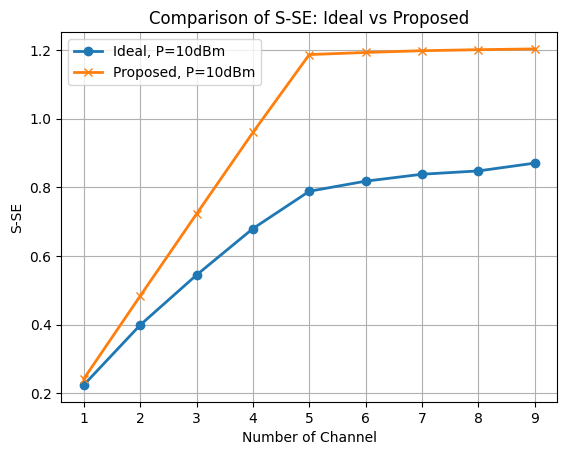

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

def main():
    # -------------------------------------------
    # Record the simulation start time
    # -------------------------------------------
    start_time = time.time()

    # -----------------------------------------------------------------------------------------------------
    # [Parameter Settings]
    # -----------------------------------------------------------------------------------------------------
    n_devices = 5               # Number of devices (users) participating in the simulation
    radius = 500                # Radius of the area where devices are located (in meters)
    p_noise = 180000 * (10 ** (-17.4))  # Noise power (using constant and reference noise power at -174 dBm/Hz) Bandwidth : 180 KHz
    shadow_factor = 6           # Shadow fading factor (typically 6-8 dB in urban environments)
    p_values = [10]             # Transmit power (in dB): fixed at 10 dB in this simulation
    SE_th = 1                   # Minimum required spectral efficiency (bit/s/Hz)
    episode = 1000              # Number of simulation repetitions (episodes)
    n_sym = np.arange(1, 20, 1)   # Available symbol count options (from 1 to 19)
    t_factor = 5 * 8            # Bits per transmission unit (word); i.e., 5 bytes x 8 = 40 bits
    channel = np.arange(1, 10)  # Channel indices, from 1 to 9

    # -----------------------------------------------------------------------------------------------------
    # Initialize lists for storing simulation results
    # -----------------------------------------------------------------------------------------------------
    TR_results_ideal = []                     # Ideal system results (Ideal SE, divided by t_factor)
    SE_results_proposed = []                  # Proposed system results (maximum SSE)
    SE_results_ideal_applicable = []          # Ideal_applicable: results recomputed (using Proposed method for matched links, NOT divided by 40)
    avg_sym_per_channel = []                  # Average number of selected symbols per channel for the proposed system

    # -----------------------------------------------------------------------------------------------------
    # [Load sem_table]
    # -----------------------------------------------------------------------------------------------------
    # sem_table: Pre-calculated table of f_n values for each symbol count and SNR range (stored as tab-delimited values)
    sem_table = np.loadtxt('/content/drive/MyDrive/sem_table.csv', delimiter='\t')

    # -----------------------------------------------------------------------------------------------------
    # Run simulation for each transmit power value (p_val)
    # -----------------------------------------------------------------------------------------------------
    for p_val in p_values:  # Fixed transmit power: 10 dB
        # -------------------------------
        # 1. Ideal System Simulation (using TR divided by t_factor)
        # -------------------------------
        ideal_TR_per_channel = []  # Temporary storage for ideal system results per channel

        # Loop over channels 1 to 10
        for n_ch in channel:
            ideal_TR_episode = []  # Store ideal system results for each episode

            for _ in range(episode):
                # -------------------------------
                # Calculate distances and path loss using the 3GPP LTE Macro-cell Urban Path Loss model
                # -------------------------------
                d = radius * np.sqrt(np.random.rand(n_devices))
                h_large_scale = 10 ** (-(128.1 + 37.6 * np.log10(d / 1000) + shadow_factor) / 10)

                # -------------------------------
                # Small scale fading: Rayleigh fading
                # Generate real and imaginary parts with standard normal distribution and compute the average energy
                # -------------------------------
                h_real = np.random.randn(n_devices, n_ch)
                h_image = np.random.randn(n_devices, n_ch)
                h_small_scale = (h_real**2 + h_image**2) / 2

                # -------------------------------
                # Ideal System: Compute spectral efficiency (SE) for each link using the Shannon formula
                # -------------------------------
                TR = np.zeros((n_devices, n_ch))
                for i in range(n_devices):
                    for j in range(n_ch):
                        # Note: Bandwidth is omitted because when computing semantic similarity it is pre-divided by bandwidth.
                        snr = (10 ** (p_val / 10)) * (h_large_scale[i] * h_small_scale[i, j]) / p_noise
                        TR[i, j] = np.log2(1 + snr)
                        if TR[i, j] < SE_th:
                            TR[i, j] = 0

                # Use the Hungarian algorithm for optimal matching (minimization by passing -TR)
                matching, rate = Hungarian(-TR)
                ideal_TR_episode.append(-rate)

            # For each channel, compute the average Ideal SE and then divide by t_factor
            ideal_TR_per_channel.append(np.mean(ideal_TR_episode) / t_factor)

        TR_results_ideal.append(np.array(ideal_TR_per_channel))

        # -------------------------------------------------------------------------
        # 2. Proposed System Simulation
        # -------------------------------------------------------------------------
        snr_range = np.arange(-10, 21)  # SNR range in dB: from -10 to 20
        f_th = 0.9                     # Threshold for f_n values in the sem_table
        s_th = SE_th / t_factor         # Minimum required SE per symbol            bit/s/Hz -> suts/s/Hz

        Proposed_SE_per_channel = []         # Store optimal SE (maximum SSE) per episode

        for n_ch in channel:
            Proposed_SE_episode = []  # Record optimal SE for each episode

            for _ in range(episode):
                d = radius * np.sqrt(np.random.rand(n_devices))
                h_large_scale = 10 ** (-(128.1 + 37.6 * np.log10(d / 1000) + shadow_factor) / 10)
                h_real = np.random.randn(n_devices, n_ch)
                h_image = np.random.randn(n_devices, n_ch)
                h_small_scale = (h_real**2 + h_image**2) / 2

                SE = np.zeros((n_devices, n_ch))

                for i in range(n_devices):
                    for j in range(n_ch):
                        snr = (10 ** (p_val / 10)) * (h_large_scale[i] * h_small_scale[i, j]) / p_noise
                        snr_db = 10 * np.log10(snr)
                        snr_db = np.clip(snr_db, snr_range[0], snr_range[-1])  # Clipping the SNR to specified range
                        snr_index = int(round(snr_db)) - int(snr_range[0])

                        best_sse = 0
                        best_sym = 20
                        for sym in n_sym:
                            f_n = sem_table[sym - 1, snr_index]
                            if f_n < f_th:
                                f_n = 0
                            SE_n = f_n / sym
                            if SE_n < s_th:
                                SE_n = 0
                            if SE_n > best_sse:
                                best_sse = SE_n
                                best_sym = sym
                                break
                        SE[i, j] = best_sse

                # Use the Hungarian algorithm for optimal matching (minimization by using -SE)
                matching, rate = Hungarian(-SE)
                Proposed_SE_episode.append(-rate)

            Proposed_SE_per_channel.append(np.mean(Proposed_SE_episode))

        SE_results_proposed.append(np.array(Proposed_SE_per_channel))




    # 배열로 변환
    TR_results_ideal = np.array(TR_results_ideal)         # shape: (len(p_values), 10)
    SE_results_proposed = np.array(SE_results_proposed)     # shape: (len(p_values), 10)

    # -----------------------------------------------------------------------------------------------------
    # [Plot and Output Results]
    # -----------------------------------------------------------------------------------------------------
    # Plot comparison of Ideal and Proposed S-SE
    plt.figure()
    plt.title('Comparison of S-SE: Ideal vs Proposed')
    plt.xlabel('Number of Channel')
    plt.ylabel('S-SE')
    plt.grid(True)
    for i, p_val in enumerate(p_values):
        plt.plot(channel, TR_results_ideal[i, :], '-o', linewidth=2, label=f'Ideal, P={p_val}dBm')
        plt.plot(channel, SE_results_proposed[i, :], '-x', linewidth=2, label=f'Proposed, P={p_val}dBm')
    plt.legend()

    # Print total simulation elapsed time
    elapsed = time.time() - start_time
    print(f"Simulation complete, elapsed time: {elapsed:.2f} sec")
    plt.show()

if __name__ == '__main__':
    main()
